# Two-dimenional Langevin Field-Theoretic Simulation

This script runs Langevin field-theoretic simulation (L-FTS) in two dimentional spaces with AB diblock copolymer systems adopting discrete chain model. Note that two-dimensional L-FTS has no physical meaning. This is only for the pedagogical purpose. 

1. L-FTS is a partial saddle-point approximation (PSPA) method that approximates the functional represention of canonical partition function by evaluating the following equation:
\begin{align}
\mathcal{Z} \propto \int \exp(-\beta H[\{\Omega_r\},\{w_i\}]) \{\mathcal{D}\Omega_r\},
\end{align}
where $\{\Omega_r\}$ is a set of real fields and $\{w_i\}$ is a set of saddle-point solutions of imaginary fields. $\{\mathcal{D}\Omega_r\}$ are functional integrals over all real function.

2. In L-FTS, the real fields are evolving according to the Langevin dynamics:
\begin{align}
\frac{\partial }{\partial \tau}\Omega_i({\bf r}, \tau) &= -λ_i \frac{\delta H[\{\Omega_r\},\{w_i\}]}{\delta \Omega_i({\bf r}, \tau)} + \eta({\bf r},\tau),  \ \ \ \ (\textrm{per monomer unit}) \\
\end{align}
with noise statistics $\left<\eta({\bf r},\tau)\right> = 0$, $\left<\eta({\bf r},\tau)\eta({\bf r'},\tau')\right> =2\lambda_i k_B T \delta({\bf r}-{\bf r}')\delta(t-t')$. 
<!-- For convinience, we choose $\lambda_i = \frac{\beta }{\rho_0}$. -->

3. In discretized grids,
\begin{align}
\lambda_i &\rightarrow \frac{\beta}{\rho_0}\lambda_i \\
\Omega_i({\bf r}, \tau+\delta\tau) &= \Omega_i({\bf r}, \tau) -λ_i\frac{\beta}{\rho_0}\frac{\delta H[\{\Omega_r\},\{w_i\}]}{\delta \Omega_i({\bf r}, \tau)} \delta\tau + \sigma_i\mathcal{N}({\bf r}, \tau),  \ \ \ \ (\textrm{per monomer unit}) \\
\end{align}
where $\mathcal{N}$ is Gaussian noise with $\sigma_i^2 = \lambda_i\frac{2\delta\tau}{\Delta V \rho_0}$.

4. In 'per chain' unit,
\begin{align}
N\Omega_i &\rightarrow \Omega_i, \\
\Omega_i({\bf r}, \tau+\delta\tau) &= \Omega_i({\bf r}, \tau) -λ_i\frac{\beta}{C/R_0^3}\frac{\delta H[\{\Omega_r\},\{w_i\}]}{\delta \Omega_i({\bf r}, \tau)} \delta\tau N + \sigma_i\mathcal{N}({\bf r}, \tau),  \ \ \ \ (\textrm{per chain unit}) \\
\end{align}
where $\mathcal{N}$ is Gaussian noise with $\sigma_i^2 = \lambda_i\frac{2\delta\tau N^2}{\Delta V \rho_0}$.

5. The invariant polymerization index $\bar{N} = a^6\rho_0^2 N$. Then, $\sigma_i^2$ can be rewritten as
\begin{align}
\Delta V \rho_0 &= \frac{\Delta V}{(aN^{1/2})^3} N \sqrt{\bar{N}}, \\
\sigma_i^2 &= \lambda_i\frac{2\delta\tau N}{\frac{\Delta V}{(aN^{1/2})^3}\sqrt{\bar{N}}}.  \ \ \ \ (\textrm{per chain unit}) \\
\end{align}

##### Example 1) AB-type polymeric systems 

\begin{align}
\Omega_-({\bf r}, \tau+\delta\tau) &= \Omega_-({\bf r}, \tau) + \left[\Phi_-({\bf r},\tau) + \frac{2}{\chi}\Omega_-({\bf r},\tau)\right] \delta\tau + \sigma \mathcal{N}_\sigma({\bf r}, \tau),  \ \ \ \ (\textrm{per monomer unit}) \\
\end{align}

\begin{align}
\Omega_-({\bf r}, \tau+\delta\tau) &= \Omega_-({\bf r}, \tau) + \left[\Phi_-({\bf r},\tau) + \frac{2}{\chi N}\Omega_-({\bf r},\tau)\right] \delta\tau N + \sigma \mathcal{N}_\sigma({\bf r}, \tau)  \ \ \ \ (\textrm{per chain unit})
\end{align}

References :
* [Monte Carlo Field-Theoretic Simulations for Melts of Symmetric Diblock Copolymer](https://doi.org/10.1021/ma401687j)
* [Computationally Efficient Field-Theoretic Simulations for Block Copolymer Melts](https://doi.org/10.1021/acs.macromol.9b01904)
* [A multi-species exchange model for fully fluctuating polymer field theory simulations](https://aip.scitation.org/doi/pdf/10.1063/1.4900574)

### 1. Setting simulation parameters and initialization

Static simulation parameters:
\begin{align}
N &= 100 \\
\Delta s &= 1/N = 0.01 \\
R_0 & = bN^{1/2} \\
L_x &= 3.0 R_0 \\
L_y &= 3.0 R_0 \\
V &= L_x L_y \\ 
m_x &= 32 \\
m_y &= 32 \\
b_A/b &= 1.0 \\
b_B/b &= 1.0 \\  
\chi_b N &= 20 \\
\end{align}

Langevin dynamics parameters:
\begin{align}
\bar{N} &= 10000 \\
\Delta \tau N &= 0.1 \\
\end{align}


In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import polymerfts

# OpenMP environment variables
os.environ["MKL_NUM_THREADS"] = "1"  # always 1
os.environ["OMP_STACKSIZE"] = "1G"
os.environ["OMP_MAX_ACTIVE_LEVELS"] = "1"  # 0, 1
os.environ["OMP_NUM_THREADS"] = "2"  # 1 ~ 4

# GPU environment variables
os.environ["LFTS_GPU_NUM_BLOCKS"]  = "256"
os.environ["LFTS_GPU_NUM_THREADS"] = "256"
os.environ["LFTS_NUM_GPUS"] = "1" # 1 ~ 2

# Simulation parameters
nx = [32,32]                       # grid number
lx = [3.0,3.0]                     # box size
stat_seg_lengths = {"A":1.0,       # statistical segment lengths
                    "B":1.0}        
ds = 0.01                          # contour step interval
chi_n = {"A,B":20}                 # bare chi interaction parameter
monomer_types = ["A", "B"]         # monomer types

# Langevin dynamics parameters
nsteps = 1000                      # number of Langevin steps
dt   = 0.1                         # Langevin step interval, delta tau*N
nbar = 10000                       # invariant polymerization index
sigma = np.sqrt(2*dt*np.prod(nx)/(np.prod(lx)*np.sqrt(nbar))) # Langevin noise amplitude

# Select platform ("cuda" or "cpu-mkl") for real-valued simulations
reduce_gpu_memory_usage = False
factory = polymerfts.PlatformSelector.create_factory("cpu-mkl", reduce_gpu_memory_usage, "real")
factory.display_info()

# Create an instance for computation box
cb = factory.create_computation_box(nx, lx) 
# Create an instance for molecule information with block segment information and chain model ("continuous" or "discrete")
molecules = factory.create_molecules_information("discrete", ds, stat_seg_lengths)

# Add AB diblock copolymers
volume_fraction = 1.0
blocks = [["A", 0.5, 0, 1],   # monomer type, statistical segment length, start index, end index
          ["B", 0.5, 1, 2]]
molecules.add_polymer(volume_fraction, blocks)

# Optimizer to avoid redundant computations
aggregate_propagator_computation = True
propagator_computation_optimizer = factory.create_propagator_computation_optimizer(molecules, aggregate_propagator_computation)
propagator_computation_optimizer.display_blocks()
propagator_computation_optimizer.display_propagators()

# Create a solver
solver = factory.create_pseudospectral_solver(cb, molecules, propagator_computation_optimizer)

==================== MKL Version ====================
Major version:           2021
Minor version:           0
Update version:          4
Product status:          Product
Build:                   20210904
Platform:                Intel(R) 64 architecture
Processor optimization:  Intel(R) Architecture processors
--------------- Blocks ---------------
Polymer id, left key:
	aggregated, (left, right) is_junction, (left, right) n_segment, right key, n_repeat, {v, u} list

0, A:
	 X, (X, O), (50, 50), (B50)A, 1, {0,1}

0, B:
	 X, (X, O), (50, 50), (A50)B, 1, {2,1}
--------------- Propagators ---------------
Key:
	height, aggregated, max_n_segment, # dependencies, junction_ends
B:
	 0, X, 50, 0, {50}, 
A:
	 0, X, 50, 0, {50}, 
(B50)A:
	 1, X, 50, 1, {}, 
(A50)B:
	 1, X, 50, 1, {}, 
(Total number of integral equation steps (time complexity to compute propagators: 200
Total number of steps after optimizing computation : 200
Computational cost reduction (higher is better) : 0 %


### 2. Initial potential fields

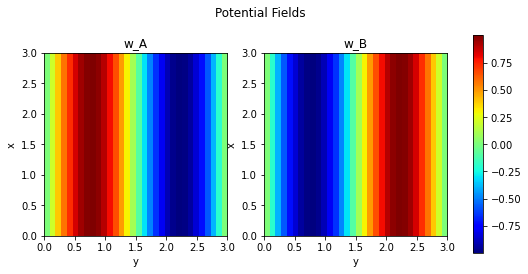

In [11]:
w_A =  np.tile(np.sin(np.linspace(0, 2*np.pi, nx[0])), (nx[1], 1))   # sinusoidal potential field for A
w_B = -np.tile(np.sin(np.linspace(0, 2*np.pi, nx[0])), (nx[1], 1))   # sinusoidal potential field for B
w = {"A": np.reshape(w_A, np.prod(nx)), "B": np.reshape(w_B, np.prod(nx))}  # potential field dictionary

# Plot each image with the same vmin and vmax
vmin = min(w_A.min(), w_B.min())
vmax = max(w_A.max(), w_B.max())

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
fig.suptitle("Potential Fields")
im = axes[0].imshow(w_A, extent=(0, lx[1], 0, lx[0]), origin='lower', cmap=cm.jet, vmin=vmin, vmax=vmax)
im = axes[1].imshow(w_B, extent=(0, lx[1], 0, lx[0]), origin='lower', cmap=cm.jet, vmin=vmin, vmax=vmax)
axes[0].set(title='w_A', xlabel='y', ylabel='x')
axes[1].set(title='w_B', xlabel='y', ylabel='x')

fig.subplots_adjust(right=1.0)
fig.colorbar(im, ax=axes.ravel().tolist())
fig.show()

### 3. Finding the saddle-point solutions using an iterative method

Update the potential fields using the equations below: 

\begin{align}
{\bf R}_w &= X{\boldsymbol\phi} − P{\bf w}, \\
w_i({\bf r}, \tau+1) &= w_i({\bf r}, \tau) + \lambda_i ({\bf R}_w)_i, \\
\end{align}
where $\lambda_i$ is an update rate and $\tau$ is the iteration number.

##### Example 1) AB-type polymeric systems 

\begin{align}
\Omega_-({\bf r}, \tau+\Delta\tau) &= \Omega_-({\bf r}, \tau) + \lambda_A \left[\chi N \phi_B({\bf r}) - \frac{1}{2}(w_A({\bf r},\tau)-w_B({\bf r},\tau)) \right], \\
\end{align}

\begin{align}
w_B({\bf r}, \tau+1) &= w_B({\bf r}, \tau) + \lambda_B \left[\chi N \phi_A({\bf r}) + \frac{1}{2}(w_A({\bf r},\tau)-w_B({\bf r},\tau)) \right]. \\
\end{align}


In [5]:
tolerance = 1.0e-5  # convergence tolerance
lambda_update = 0.5  # fields update rate

# The number of components
M = len(monomer_types)

# X (χN matrix) and its inverse
matrix_chi = np.array([
    [0, chi_n["A,B"]],
    [chi_n["A,B"], 0]]
)
matrix_chi_inv = np.linalg.inv(matrix_chi)

# P matrix for field residuals
matrix_p = np.identity(M) - np.matmul(np.ones((M,M)), matrix_chi_inv)/np.sum(matrix_chi_inv)

def compute_concentrations(w):
    # For the given fields, compute the polymer statistics
    solver.compute_propagators(w)
    solver.compute_concentrations()

    # Compute total concentration for each monomer type
    phi = {}
    for monomer_type in monomer_types:
        phi[monomer_type] = solver.get_total_concentration(monomer_type)

    return phi

# Assign large initial value for the energy and error
energy_total = 1.0e20
error_level = 1.0e20

# Iteration begins here
print("---------- Run ----------")
print("iteration, mass error, total_partitions, free_energy, error_level")
for scft_iter in range(1000):
    # Compute total concentration for each monomer type
    phi = compute_concentrations(w)

    # Calculate the total energy
    total_partitions = [solver.get_total_partition(p) for p in range(molecules.get_n_polymer_types())]
    energy_total = 0.0
    for i in range(M):
        energy_total -= np.mean(w[monomer_types[i]]*phi[monomer_types[i]])
        for j in range(M):
            energy_total += 0.5*matrix_chi[i,j]*np.mean(phi[monomer_types[i]]*phi[monomer_types[j]])

    # Calculate difference between current total density and target density
    phi_total = np.zeros(cb.get_total_grid())
    for i in range(M):
        phi_total += phi[monomer_types[i]]
    phi_diff = phi_total-1.0

    # Calculate self-consistency error
    w_diff = np.zeros([M, cb.get_total_grid()], dtype=np.float64) # array for output fields
    for i in range(M):
        for j in range(M):
            w_diff[i,:] += matrix_chi[i,j]*phi[monomer_types[j]] - matrix_p[i,j]*w[monomer_types[j]]

    # Keep the level of functional derivatives
    for i in range(M):
        w_diff[i] -= cb.integral(w_diff[i])/cb.get_volume()

    # error_level measures the "relative distance" between the input and output fields
    old_error_level = error_level
    error_level = 0.0
    error_normal = 1.0  # add 1.0 to prevent divergence
    for i in range(M):
        error_level += cb.inner_product(w_diff[i],w_diff[i])
        error_normal += cb.inner_product(w[monomer_types[i]],w[monomer_types[i]])
    error_level = np.sqrt(error_level/error_normal)

    # Print iteration # and error levels and check the mass conservation
    mass_error = cb.integral(phi_diff)/cb.get_volume()
    
    print("%8d %12.3E " % (scft_iter, mass_error), end=" [ ")
    for p in range(molecules.get_n_polymer_types()):
        print("%13.7E " % (solver.get_total_partition(p)), end=" ")
    print("] %15.9f %15.7E " % (energy_total, error_level))

    # Conditions to end the iteration
    if error_level < tolerance:
        break

    # Update fields using simple
    for i in range(M):
        w[monomer_types[i]] += lambda_update*w_diff[i]

---------- Run ----------
iteration, mass error, total_partitions, free_energy, error_level
       0    2.304E-15  [ 1.0230026E+00  ]     5.024198126   9.8481101E-02 
       1    2.800E-15  [ 1.0217622E+00  ]     5.023094753   1.3522720E-01 
       2   -1.294E-15  [ 1.0206932E+00  ]     5.022456780   2.3527564E-01 
       3   -1.857E-15  [ 1.0208004E+00  ]     5.028834515   5.4761402E-01 
       4   -3.183E-15  [ 1.0266454E+00  ]     5.088597037   1.5862075E+00 
       5   -1.863E-15  [ 1.0838615E+00  ]     5.574325767   3.7438856E+00 
       6   -2.196E-15  [ 1.5382690E+00  ]     8.225964870   5.6037036E+00 
       7    7.883E-16  [ 3.9777158E+00  ]    11.042883322   3.4405812E+00 
       8    5.426E-16  [ 3.4970310E+00  ]     9.525217220   2.7504343E+00 
       9   -3.939E-16  [ 1.6083607E+00  ]     7.888346586   3.9392100E+00 
      10    2.419E-15  [ 3.8098373E+00  ]    13.646528113   5.2141729E+00 
      11    7.895E-16  [ 6.5929380E+00  ]    10.044478924   1.8378816E+00 
      12

### 4. Display the results

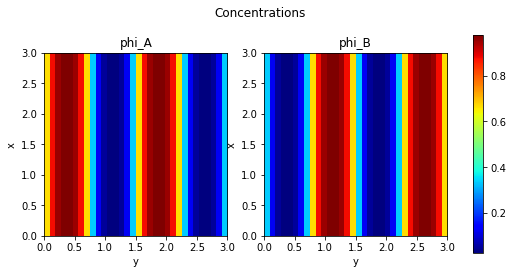

In [6]:
# Get the ensemble average concentration for each monomer type
phi_A = np.reshape(solver.get_total_concentration("A"), nx)
phi_B = np.reshape(solver.get_total_concentration("B"), nx)

# Plot each image with the same vmin and vmax
vmin = min(phi_A.min(), phi_B.min())
vmax = max(phi_A.max(), phi_B.max())

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
fig.suptitle("Concentrations")
im = axes[0].imshow(phi_A, extent=(0, lx[1], 0, lx[0]), origin='lower', cmap=cm.jet, vmin=vmin, vmax=vmax)
im = axes[1].imshow(phi_B, extent=(0, lx[1], 0, lx[0]), origin='lower', cmap=cm.jet, vmin=vmin, vmax=vmax)
axes[0].set(title='phi_A', xlabel='y', ylabel='x')
axes[1].set(title='phi_B', xlabel='y', ylabel='x')

fig.subplots_adjust(right=1.0)
fig.colorbar(im, ax=axes.ravel().tolist())
fig.show()